# 7: Numerics in Firedrake

Implementing the Godunov scheme as detailed in previous sections.

In [11]:
import numpy as np

def closest_index(array: list, value: float) -> int:
    """Find the index of the closest value in an array.

    Args:
        array (list): The array to search.
        value (float): The value to find.

    Returns:
        int: The index of the closest value.
    """
    array = np.asarray(array)
    index = (np.abs(array - value)).argmin()
    return index

In [12]:
class River(object):
    def __init__(self, h0: float, w0: float, L: float, Cm: float = 0.1, g: float = 9.81, dsb: float = -0.001):
        self.h0: float = h0  # initial depth (m)
        self.w0: float = w0  # initial width (m)
        self.L: float = L    # length of the river reach (m)
        self.Cm: float = Cm  # Manning's roughness coefficient
        self.g: float = g    # gravitational acceleration (m/s^2)
        self.dsb: float = dsb  # bed slope

    def build_grid(self, nx):
        self.nx: int = nx
        self.dx: float = self.L / (self.nx - 1)
        self.x: list[float] = [i * self.dx for i in range(self.nx)]

    def is_built(self):
        return hasattr(self, 'nx') and hasattr(self, 'dx') and hasattr(self, 'x')
    
    def P(self, A):
        return self.w0 + 2 * A / self.w0

    def flux(self, A):
        result = A ** (5/3) * (-1 * self.dsb) ** 0.5 / (self.Cm * self.P(A) ** (2/3))
        if isinstance(result, complex):
            print(f'Flux calculation resulted in complex number for A={A}')
            raise ValueError("Flux calculation resulted in a complex number.")
        
        return result

    def velocity(self, A):
        return (A / self.P(A)) ** (2/3) * (-1 * self.dsb) ** 0.5 / self.Cm
    
    def Q(self, A):
        return A * self.velocity(A)

In [23]:

class BoundaryConditions(object):
    def __init__(self, w: list[float], h: list[float], times: list[float]):
        self.w = w
        self.h = h
        self.times = times

    def convert_times_hours(self):
        self.times_hours = [t/3600 for t in self.times]

    def plot(self):
        import matplotlib.pyplot as plt
        
        self.convert_times_hours()
        plt.figure()
        plt.plot(self.times_hours, self.h)
        plt.xlabel('Time (hours)')
        plt.ylabel('Water Depth (m)')
        plt.title('Boundary Conditions: Water Depth over Time')
        plt.show()

class InitialConditions(object):
    def __init__(self, A: list[float], w: list[float], positions: list[float]):
        self.A = A
        self.w = w
        self.positions = positions

class Solution(River):
    def __init__(self, river: River, times: list[float], A: list[list[float]], w: list[list[float]]):
        super().__init__(river.h0, river.w0, river.L, river.Cm, river.g, river.dsb)

        self.times = times
        self.A = A  # 2D list: time x space
        self.w = w  # 2D list: time x space, note that currently it is assumed constant through time

        self.build_grid(river.nx)

    def convert_times(self):
        self.times_hours = [t / 3600 for t in self.times]

    def plot_time(self, time_index: int):
        import matplotlib.pyplot as plt

        assert self.is_built(), "River grid must be built before plotting solution."
        assert 0 <= time_index < len(self.times), "Invalid time index."

        # Convert to hours 
        self.convert_times()

        plt.figure()
        plt.plot(self.x, self.A[time_index], label=f'Time = {self.times_hours[time_index]:.2f} hours')
        plt.xlabel('Distance along river (m)')
        plt.ylabel('Cross-sectional Area (m²)')
        plt.title('River Cross-Section at Specific Time')
        plt.legend()
        plt.show()

    def plot_15_hours(self, start_time_hours: float ):
        """
        Plot the river cross-section at a sequence of times arranged in a grid with `rows` rows.
        The number of columns is determined automatically to fit all time steps.

        Each subplot shows a single timestamp (so you can see the river condition through time).
        """
        import matplotlib.pyplot as plt
        import numpy as np

        assert self.is_built(), "River grid must be built before plotting solution."

        # Convert times to hours for labelling and colouring
        self.convert_times()
        start_time_index = closest_index(self.times_hours, start_time_hours)

        rows = 5
        cols = 3

        # Figure as below but with set size
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True, sharey=True)
        # flatten axes array for easy indexing (works when rows*cols > 1)
        axes_flat = np.array(axes).reshape(-1)

        cmap = plt.get_cmap('hsv')
        norm = plt.Normalize(vmin=0, vmax=200)

        # Check all A are floats/ints
        
        # Collect the invalid entries and print
        invalid_entries = [(i, a) for i, a in enumerate(self.A) if not all(isinstance(val, (float, int)) for val in a)]
        print(f"Invalid entries in A at indices: {invalid_entries}")
        if len(invalid_entries) > 0:
            raise ValueError("All values in A must be floats.")

        
        maximum = max(max(a) for a in self.A)

        for time in range(rows * cols):
            idx = closest_index(self.times_hours, time) + start_time_index
            ax = axes_flat[time]
            if idx < len(self.times_hours):
                # Find mean of A for this time
                A_mean = sum(self.A[idx]) / len(self.A[idx])
                color = cmap(norm(A_mean))
                ax.plot(self.x, self.A[idx], color=color)
                ax.set_title(f'Time = {self.times_hours[idx]:.2f} h')
                ax.set_xlabel('Distance (m)')
                ax.set_ylabel('Area (m²)')
                ax.set_ylim(0, maximum * 1.1)
                ax.grid(True)
            else:
                # Hide unused subplots
                ax.axis('off')

        plt.tight_layout()
        plt.show()

    def plot_discharge_end(self, statistics: bool = False):
        import matplotlib.pyplot as plt

        discharge_end = [self.A[i][-1] * self.velocity(self.A[i][-1]) for i in range(len(self.times))]
        
        # Find maximum discharge and time of maximum discharge
        max_discharge = max(discharge_end)
        max_time = self.times_hours[discharge_end.index(max_discharge)]
        if statistics:
            print(f"Maximum discharge at downstream end: {max_discharge:.2f} m³/s at time {max_time:.2f} hours")


        self.convert_times()

        plt.figure()
        plt.plot(self.times_hours, discharge_end)
        plt.xlabel('Time (s)')
        plt.ylabel('Discharge at downstream end (m³/s)')
        plt.title('Discharge at Downstream End Over Time')
        plt.show()

class GodunovSolver(object):
    def __init__(self):
        pass

    def solve(self, river: River, bc: BoundaryConditions, ic: InitialConditions, t_final: float, dt: float) -> Solution:
        # If dt = None, compute dt based on CFL condition
        
        times = [0.0]
        A = [ic.A.copy()]
        w = [ic.w.copy()]  # Assuming width is constant for simplicity

        while times[-1] < t_final:
            if len(times) % 10 == 0:
                print("\r", end="")
                print(f"Time: {times[-1]:.2f} / {t_final:.2f} s", end="")
            new_A, new_w = self.iteration(river, A[-1], w[-1], dt, bc.h[int(times[-1]/dt)])  # Using first boundary condition as example
            A.append(new_A)
            w.append(new_w)
            times.append(times[-1] + dt)
        
        return Solution(river, times, A, w)

    def iteration(self, river: River, A: list[float], w: list[float], dt: float, boundary: float):
        # Placeholder for a single iteration of the Godunov method
        new_A = A.copy()
        new_w = w.copy()

        # Assign boundary conditions from argument
        new_A[0] = boundary

        for i in range(1, len(A)):
            # Fluxes for k+1/2 and k-1/2
            F_plus = river.flux(A[i])
            F_minus = river.flux(A[i - 1])

            # Update
            new_A[i] = A[i] - (dt / river.dx) * (F_plus - F_minus)

        return new_A, new_w
            


In [24]:
from typing import Optional
import numpy as np
import math

# Define a initial conditions for constant area and width 
def constant_ic(river: River) -> InitialConditions:
    A0 = river.h0 * river.w0
    A: list[float] = [A0 for _ in range(river.nx)]
    w: list[float] = [river.w0 for _ in range(river.nx)]
    positions: list[float] = river.x.copy()
    return InitialConditions(A, w, positions)
def zero_ic(river: River) -> InitialConditions:
    A: list[float] = [0.0 for _ in range(river.nx)]
    w: list[float] = [river.w0 for _ in range(river.nx)]
    positions: list[float] = river.x.copy()
    return InitialConditions(A, w, positions)
# Define boundary conditions for constant area and width at the upstream end
def constant_bc(river: River, times: list[float], h: Optional[float] = None, w: Optional[float] = None) -> BoundaryConditions:
    if w is not None:
        w0 = w
    else:
        w0 = river.w0
    if h is not None:
        A0 = h * w0
    else:
        A0 = river.h0 * w0
        
    A: list[float] = [A0 for _ in times]
    w: list[float] = [w0 for _ in times]
    return BoundaryConditions(w, A, times)

def flood_bc(river: River, times: list[float], flood_multiple: float, verbosity: int = 0) -> BoundaryConditions:
    w0 = river.w0
    A0 = w0 * river.h0
        
    A: list[float] = [A0 for _ in times] # Base Profile
    w: list[float] = [w0 for _ in times]

    # Set peak_time to be 16 hours in seconds
    peak_time: int = times.index(min(times, key=lambda x: abs(x - 57600)))  # 16 hours = 57600 seconds
    # flood_profile = [A0 * t/times[peak_time] * flood_multiple for t in times[:peak_time + 1]] 
    flood_profile = [A0 * flood_multiple / times[peak_time] * (2 * times[t] - times[t] ** 2 / times[peak_time]) for t in range(peak_time + 1)]
    flood_profile += [A0 * flood_multiple * math.exp((times[peak_time] - t) / (times[peak_time])) for t in times[peak_time + 1:]]

    for i in range(len(A)):
        A[i] = A[i] + flood_profile[i]

    result = BoundaryConditions(w, A, times)

    if verbosity > 0:
        # Plot
        result.plot()

    return result

def periodic_bc(river: River, times: list, period: float, amplitude: float) -> BoundaryConditions:
    w0 = river.w0
    A0 = w0 * river.h0
        
    A: list[float] = [A0 + amplitude + amplitude * math.sin(2 * math.pi * t / period) for t in times]
    # Check all of A are floats
    if not all(isinstance(a, float) for a in A):
        raise ValueError("All values in A must be floats.")
    w: list[float] = [w0 for _ in times]
    return BoundaryConditions(w, A, times)

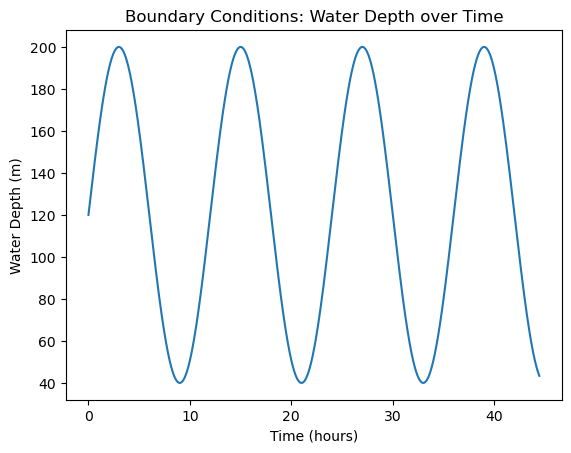

3200
Time: 159950.00 / 160000.00 s

In [25]:

L = 5000
W0 = 40
H0 = 1
dt = 50
t_final = 160000.0
river = River(H0, W0, L)
river.build_grid(nx=51)
ic: InitialConditions = constant_ic(river)
# ic: InitialConditions = zero_ic(river)
# bc = constant_bc(river, times=[np.linspace(0, t_final, num=2).tolist()], h = 6)
# bc: BoundaryConditions = flood_bc(river, times=np.linspace(0, t_final, int(t_final/dt)).tolist(), flood_multiple=4)
bc: BoundaryConditions = periodic_bc(river, times=np.linspace(0, t_final, int(t_final/dt)).tolist(), period=3600*12, amplitude=river.h0*river.w0*2)
bc.plot()
print(len(bc.h))

# for i in range(570, 601):
#     print(f'Boundary Condition at time index {i} (time={bc.times[i]}s): h = {bc.h[i]} m, w = {bc.w[i]} m')

solver = GodunovSolver()
solution = solver.solve(river, bc, ic, t_final=t_final, dt=dt)




Invalid entries in A at indices: []


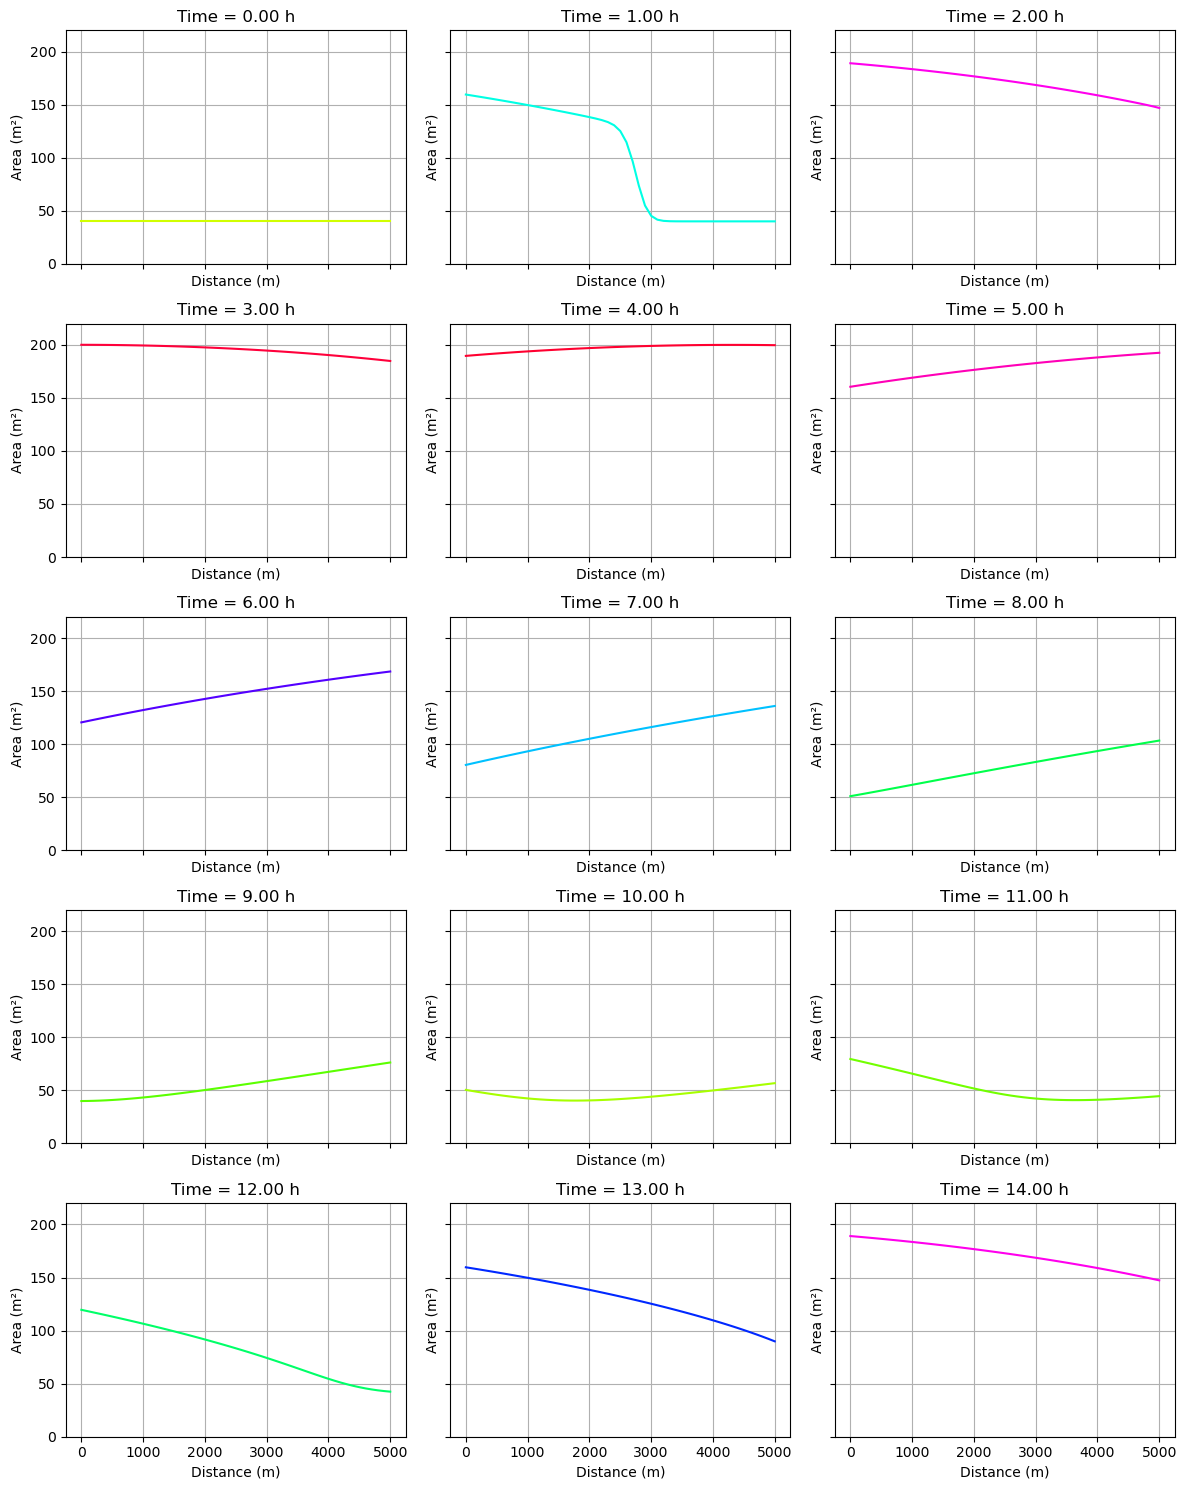

Invalid entries in A at indices: []


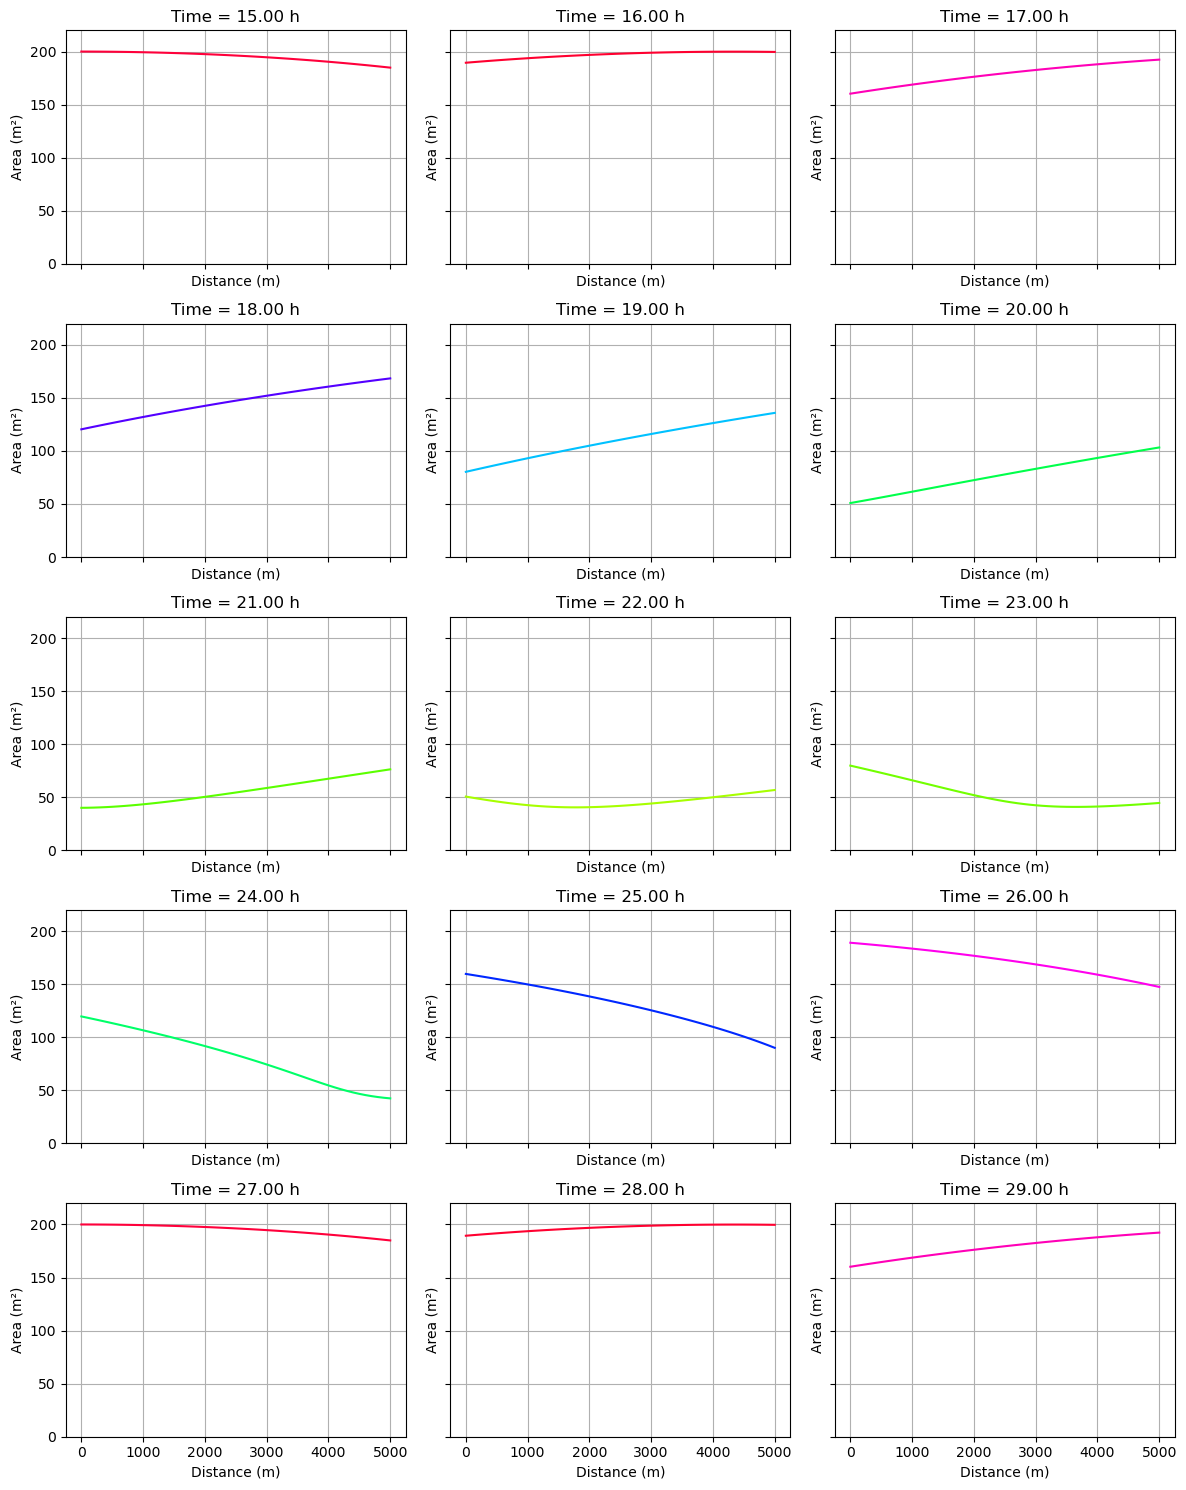

Invalid entries in A at indices: []


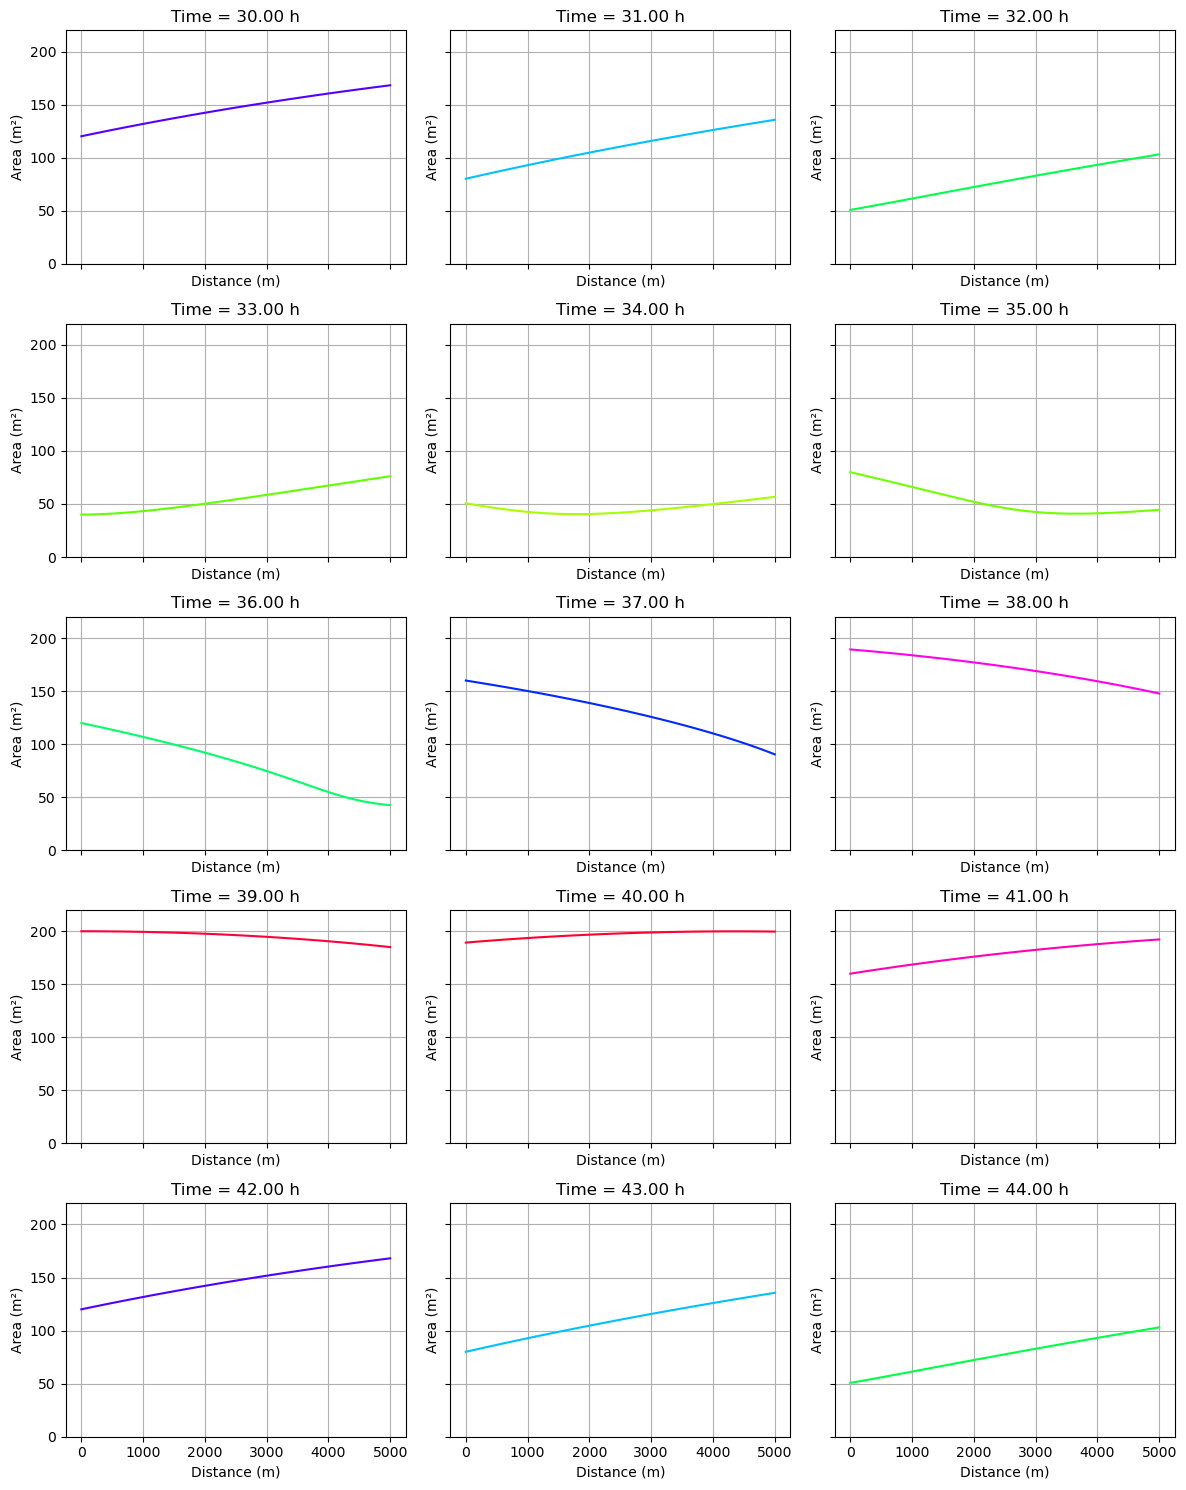

In [26]:
solution.plot_15_hours(start_time_hours=0)
solution.plot_15_hours(start_time_hours=15)
solution.plot_15_hours(start_time_hours=30)

Maximum discharge at downstream end: 159.33 m³/s at time 16.97 hours


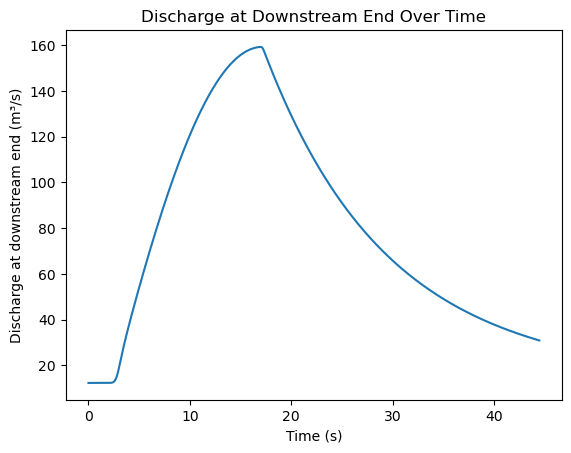

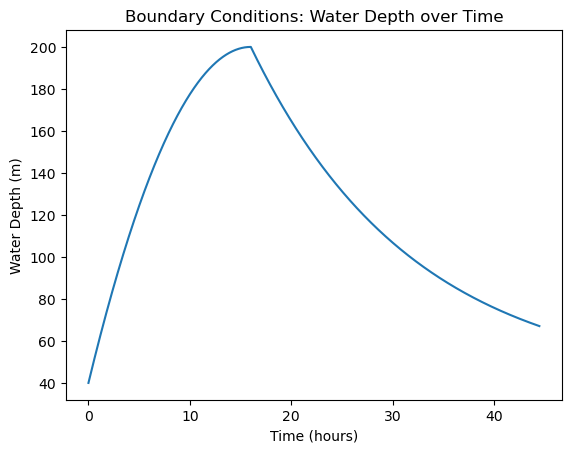

In [ ]:
solution.plot_discharge_end(statistics=True)
bc.plot()


In [ ]:
# import time
# print('This is important info!')
# for i in range(100):
#     print("\r"+'Processing BIG data file {}'.format(i),end="")
#     time.sleep(0.1)
#     if i == 50:
#         print("\r"+'Something bad happened on run {}.  This needs to be visible at the end!'.format(i))
# print("\r"+'Done.')